In [1]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic
import DifferentialEquations
import PyPlot
const plt = PyPlot
using Distributions
using Expectations

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [3]:
C = Ca40(["S-1/2", "D-1/2"])
L = Laser()
νa = 1.0e6  # axial trap frequency
νr = 3.0e6    # radial trap frequency
chain = LinearChain(ions=[C], com_frequencies=(x=νr,y=νr,z=νa), vibrational_modes=(x=[], y=[], z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;
mode = T.configuration.vibrational_modes.z[1]

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim C:\Users\suman\.julia\packages\IonSim\5Hvou\src\lasers.jl:84


VibrationalMode(ν=1.0e6, axis=ẑ, N=10)

In [4]:
get_η(mode, L, C)

0.06852224350584407

# RAP on RSB transition

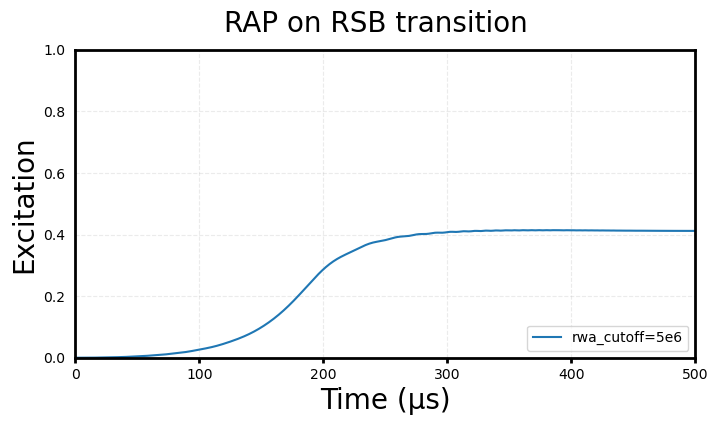

  4.029872 seconds (56.04 M allocations: 1.283 GiB, 3.16% gc time)
0.4117798371479881

PyObject <matplotlib.legend.Legend object at 0x000000003E95DF40>

In [14]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
mode.N = 50

n̄ = 0.7
#ψi = C["S-1/2"] ⊗ mode[n̄]
ψi_ion = dm(C["S-1/2"])
ψi_mode = thermalstate(mode, n̄)
ψi = ψi_ion ⊗ ψi_mode

Tp = 500 # the length of time of the frequency chirp in μs

#We’ll linearly sweep through the laser’s frequency from -100 kHz to +100 kHz detuned from the carrier transition in a time Tp
δν = 200e3 #frequency chirp length 200 kHz

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * (δν/2) * 1e-6

# Set the frequency chirp
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 2*E*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/6000) ; sin(π * t / Tp)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf - mode.ν 


tspan = 0:1:Tp
h = hamiltonian(T, rwa_cutoff=5e6)
@time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

ψo = ψt[end]  
p = expect(ionprojector(T, "D-1/2"), ψo)
print(abs(p))

ex1 = expect(ionprojector(T, "D-1/2"), ψt)

plt.plot(tout, ex1, label="rwa_cutoff=5e6")

#plt.plot(tout, @.(L.E(tout) / (2*E)), linestyle="--", label="scaled amplitude profile")

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.suptitle("RAP on RSB transition", fontsize = 20)
plt.legend(loc="lower right", fontsize = 10)

### Amplitude and frequency profile

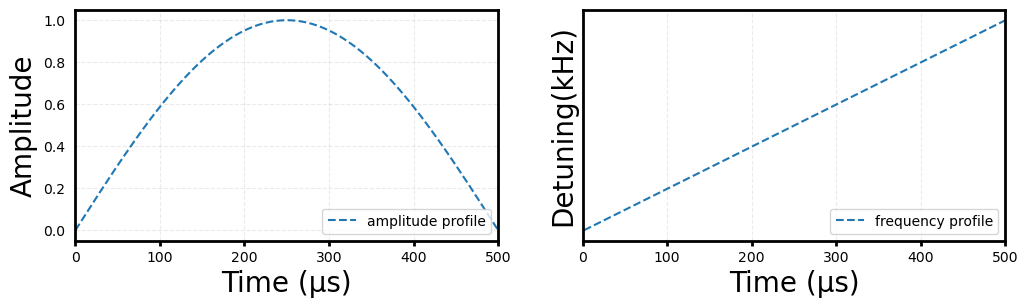

PyObject <matplotlib.legend.Legend object at 0x00000000020F0F70>

In [6]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(tout, @.(L.E(tout) / (2*E)), linestyle="--", label="amplitude profile")
plt.xlim([tout[1], tout[end]])
#plt.ylim(0, 1)
plt.ylabel("Amplitude")
plt.xlabel("Time (μs)");
plt.legend(loc="lower right", fontsize = 10)

plt.subplot(122)
plt.plot(tout, @.(L.ϕ(tout) / (2Δϕ * tout)), linestyle="--", label="frequency profile")
plt.xlim([tout[1], tout[end]])
#plt.ylim(0, 1)
plt.ylabel("Detuning(kHz)")
plt.xlabel("Time (μs)");
plt.yticks([])
plt.legend(loc="lower right", fontsize = 10)

In [7]:
p = expect(ionprojector(T, "D-1/2"), ψt[end])
p = real(p)
if p > 1
    p = 1
elseif p < 0
    p = 0
end
B = Bernoulli(p)
rand(B)

false

# theoretical_nbar

In [26]:
# n = one(C) ⊗ thermalstate(mode, 5)
# ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
# theoretical_nbar = real(expect(n, ψi))

## scaling with fock states |n>; sequence rsb RAP pulse followed by carrier pi pulse

In [ ]:
mode.N = 70
n̄ = 0.9
n = one(C) ⊗ IonSim.number(mode)

# ψi_ion = dm(C["S-1/2"])
# ψi_mode = thermalstate(mode, n̄)
# ψi = ψi_ion ⊗ ψi_mode

T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

δν = 200e3 
Tp = 500 #μs
Δϕ = 2π * (δν/2) * 1e-6

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 2*E*sin(π*t/Tp) 
    else
        return 0
    end
end

number_of_repetitions = 100
phonon_number_measurement = 0
theoretical_nbar = 0

# j = []
# r = []

for k in 1:number_of_repetitions
    ψi = dm(C["S-1/2"]) ⊗ thermalstate(mode, n̄)
#     ψi = C["S-1/2"] ⊗ mode[n̄]
    theoretical_nbar = real(expect(n, ψi))
    i = 0
    while true
        # # simulation with RAP pulse on rsb transition

        L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
        L.E = Ω;
        L.Δ  = Δf - mode.ν 


        tspan = 0:1:Tp 
        h = hamiltonian(T, rwa_cutoff=5e6)
        tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

        ψo = ψt[end]

        p = expect(ionprojector(T, "D-1/2"), ψo)
        p = real(p)
        if p > 1
            p = 1
        elseif p < 0
            p = 0
        end
        B = Bernoulli(p)
        b = rand(B, 1)[1]
        if !b
            break
        else
        # simulation with pi pulse on carrier
            L.Δ = Δf
            E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
            L.E = E
            L.ϕ = 0

            tpi = 3 # length of pi pulse|


            tlist = 0:tpi/300:tpi
            h = hamiltonian(T, rwa_cutoff=5e6)
            tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h, displacement="analytic")

            ψi = ψt[end]
#             q = expect(ionprojector(T, "S-1/2"), ψi)
#             push!(j, i)
#             push!(r, q)
            i += 1
        end
    end
    phonon_number_measurement += i
    println(phonon_number_measurement)
end

average_phonon_number_measurement = phonon_number_measurement / number_of_repetitions
error = abs(theoretical_nbar - average_phonon_number_measurement) / theoretical_nbar;
println("average: ", average_phonon_number_measurement);
println("theoretical_nbar: ", theoretical_nbar);
println("error: ", error);

2
2
3
5
7
7
7
8
8
8
8
8
9
9
9
9
9
10
10
11
11
11
11
11
11
13
15
15
16
17
18
18
19
20
21
23
23
24
24
24
26
26
26
26
26
26
26
26
26
27
27
27
27
28
28
28
28
29
30
30
30
30
30
32
33
34
34
34
35
35
36
36
36
36
38
38
38
38
39
39
40


#### num_bins = 10
n, bins, patches  = plt.hist(j, num_bins)
plt.show()
# plt.ylabel("Number of repetitions")
# plt.xlabel("Phonon number measurement");

In [227]:
mode.N = 50

n̄ = 0.2
n = one(C) ⊗ IonSim.number(mode)
ψi = dm(C["S-1/2"]) ⊗ thermalstate(mode, n̄)
#ψi = C["S-1/2"] ⊗ mode[n̄]
theoretical_nbar = real(expect(n, ψi))
print(theoretical_nbar)

0.20000000000000004

# Error scaling with theoretical n̄

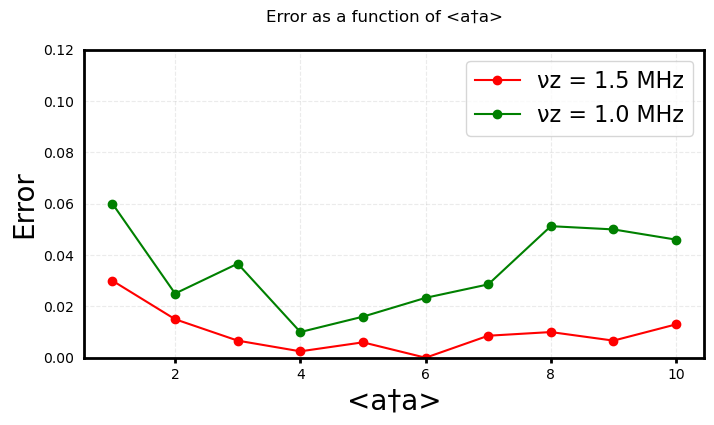

PyObject Text(0.5, 0.98, 'Error as a function of <a†a>')

In [9]:
# rwa_cutoff = 2e6
# number_of_repititions = 100
# Tp = 150
# axial_trap_freq = 1.5e6
# n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# theoretical_nbar = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# average_phonon_number_measurement = [9.91, 8.89, 7.87, 6.93, 5.87, 4.86, 3.87, 2.81, 1.89, 0.89]
# error = [0.00899, 0.01222, 0.01625, 0.01, 0.02166, 0.02799, 0.03249, 0.06333, 0.05500, 0.10999]

rwa_cutoff = 2e6
number_of_repititions = 100
Tp = 300
axial_trap_freq = 1.5e6
n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
theoretical_nbar = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
average_phonon_number_measurement = [9.87, 8.94, 7.92, 6.94, 6, 4.97, 3.99, 2.98, 1.97, 0.97]
error = [0.013, 0.00666, 0.01, 0.00857, 0, 0.006, 0.00249, 0.00666, 0.015, 0.03]


# rwa_cutoff = 1.5e6
# number_of_repititions = 100
# Tp = 300
# axial_trap_freq = 1e6
# n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
theoretical_nbar_1 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# average_phonon_number_measurement = [9.54, 8.55, 7.59, 6.8, 5.86, 4.92, 3.96, 2.89, 1.95, 0.94]
error_1 = [0.046, 0.04999, 0.05125, 0.02857, 0.02333, 0.016, 0.01, 0.03666, 0.025, 0.06]

plt.plot(theoretical_nbar, error, "ro-", label="νz = 1.5 MHz")
plt.plot(theoretical_nbar_1, error_1, "go-", label="νz = 1.0 MHz")
plt.legend(loc="upper right", fontsize = 16)
plt.ylim(0, 0.12)
plt.ylabel("Error")
plt.xlabel("<a†a>");
plt.suptitle("Error as a function of <a†a>")

### sequence of simulation; pi pulse on carrier followed by bsb RAP pulse

In [30]:
η = abs(get_η(mode, L, C))

0.07105425653011588